TODO:
- [ ] Clean up code (+functions)

PyMC compatibility:
- `testval` (old version) -> `initval` (new version)

Helper functions:

In [60]:
def my_callback(meanfield, elbo, n):
    if n%2000 == 0 and n>10000 or n == 5000:
        acc = print_acc_from_trace(meanfield, n)
        accs.append(acc)
        ns.append(n)
def ppc_to_pred(ppc):
    pred = []
    for i in range(ppc['out'].shape[1]): # for X_test samples
        one_sample = []
        for j in range(ppc['out'].shape[0]):
            one_sample.append(ppc['out'][j][i])
        sums = np.zeros(lenA)
        for s in one_sample:
            sums[s] += 1

        pred.append(np.argmax(sums))
    return np.array(pred)

Used in callback. Computes, prints and saves the accuracy at this point of learning

In [61]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

# Model1 (M1)
- Using 1 hidden layer

Note: The model is inspired on variational inference with [PyMC](https://docs.pymc.io/en/v3/pymc-examples/examples/variational_inference/variational_api_quickstart.html) framework.

In [1]:
try:
    import aesara; floatX = aesara.config.floatX
except ModuleNotFoundError:
    import theano; floatX = theano.config.floatX
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene

%config InlineBackend.figure_format = 'retina'

rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

Invalid MIT-MAGIC-COOKIE-1 key

Hyperparameters:
- Edit here!
- Pick the dataset name: D0, ... D3, D1_0 ... D4_1
- Train samples: up to 10000

In [6]:
dataset_name = 'D1_1'
train_samples = 4000 

In [7]:
# dataset 
data = np.load(f"{os.path.expanduser('./datasets')}/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [8]:
n_obs_in = lenG

In [9]:
def get_X_Y(dataset):
    X = np.zeros([len(dataset),len(dataset[0][2])])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])

        X[n] = sample[2]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset)

In [10]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-(train_samples/10000))

In [12]:
def construct_nn(nn_input, nn_output):
    n_hidden = lenA
    
    # Initialize the weights/policy values
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
    }
    with pm.Model(coords=coords) as neural_network:
        nn_input = pm.Data("nn_input", X_train)
        nn_output = pm.Data("nn_output", Y_train)

        # Weights/policy symbolic variable
        weights_in_1 = pm.Normal(
            "policy", 0, sigma=1, testval=init_1, dims=("train_cols", "hidden_layer_1")
        )
        act_out = pm.math.sigmoid(pm.math.dot(nn_input, weights_in_1))
        out = pm.Categorical("out", act_out, observed=nn_output, total_size=Y_train.shape[0])
        
    return neural_network

neural_network = construct_nn(X_train, Y_train)

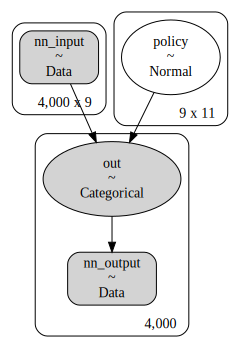

In [14]:
pm.model_to_graphviz(neural_network)

In [15]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [16]:
ns = []
accs = []
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    method = pm.ADVI()
    approx = pm.fit(n=25_000, callbacks=[my_callback], method=method)

n: 5000, Accuracy = 39.0%
n: 12000, Accuracy = 87.9%
n: 14000, Accuracy = 93.17%
n: 16000, Accuracy = 96.4%
n: 18000, Accuracy = 97.78%
n: 20000, Accuracy = 98.42%
n: 22000, Accuracy = 98.73%
n: 24000, Accuracy = 98.88%


Finished [100%]: Average Loss = 2,212.4


In [17]:
trace = approx.sample(draws=100)
with neural_network:
    pm.set_data(new_data={"nn_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
pred = ppc_to_pred(ppc)
f"Accuracy = {(pred == Y_test).mean() * 100}%"

'Accuracy = 99.21666666666667%'

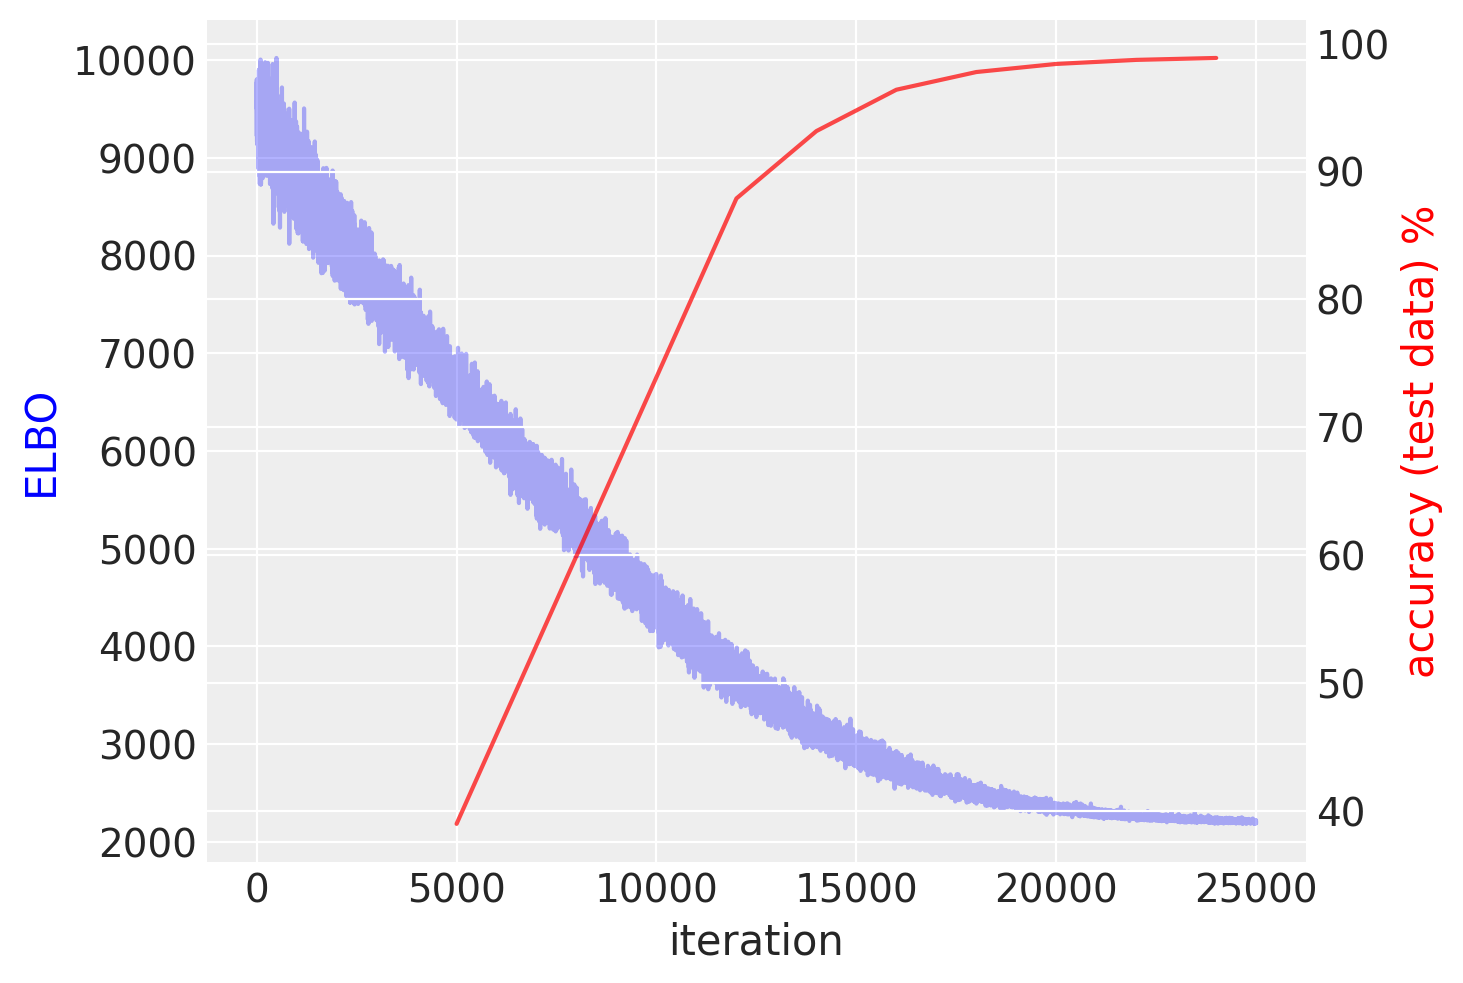

In [18]:
x = ns
y1 = approx.hist
y2 = accs

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(y1, 'blue', alpha=0.3)
ax2.plot(x, y2, 'red', alpha=0.7)

ax1.set_xlabel('iteration')
ax1.set_ylabel('ELBO', color='blue')
ax2.set_ylabel('accuracy (test data) %', color='red')

plt.show()

In [43]:
from srcmodules.nnwrapper import NNWrapper
NNWrapper.save_network(X_train, approx, neural_network, network_path=network_path, name=name, Gs=A, type='g2i', engine='PyMC3', args=[], accuracy=0, filenames=[], record_keys=[])

Saving network
Network: M1_D1_1.pkl saved


Results of Model 1 (1L, 11 Hidden layer size fixed):
- D0:
    - M(100 sm) = 20.5% (L=226 ,reached max when n~14000)
    - M(200 sm) = 30.6% (L=430, reached max when n~20000)
    - M(400 sm) = 57.1% (L=763, not reached local max)
    - M(1000sm) = 89.6% (L=1436, not reached local max)
    - M(2500sm) = 96.6% (L=2272, reached max when n~22000)
    - M(6000sm) = 98.5% (L=3400, not reached local max)
    - M(9000sm) = 
- D1:
    - M(100 sm) = 18
    - M(200 sm) = 25
    - M(400 sm) = 40
    - M(1000sm) = 62
    - M(2500sm) = 67
    - M(5000sm) = 70
    - M(9000sm) = 67    
- D2:
    - M(5000sm) = 68
- D3:
    - M(5000sm) = 68
    - M(1000sm) = 63
    - M(100 sm) =~18

## The old dataset

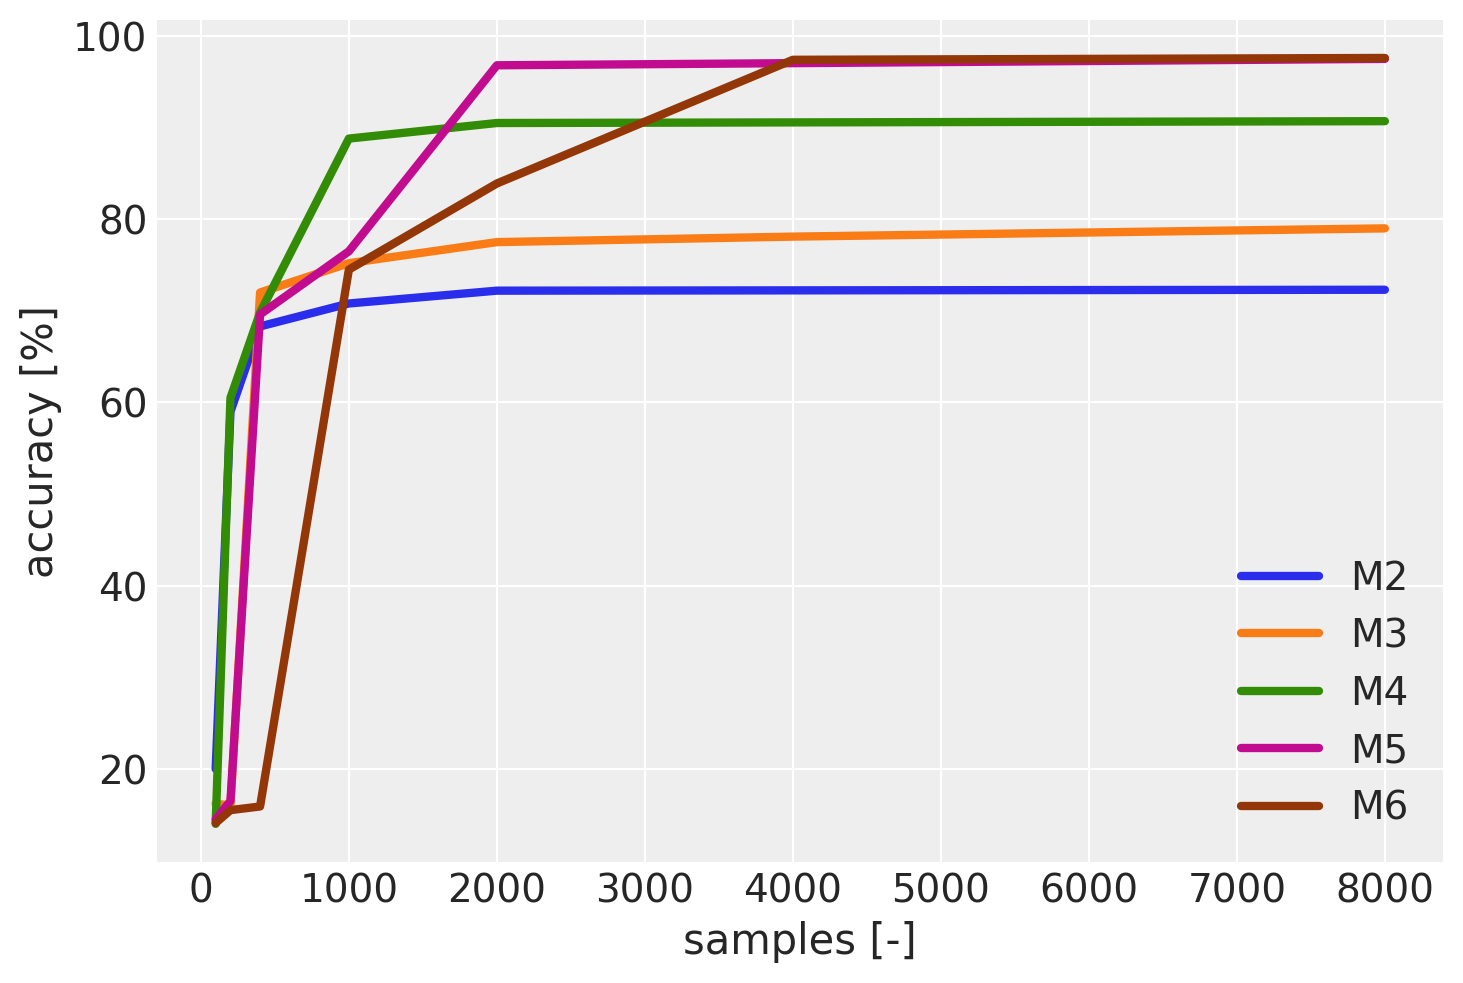

In [8]:
s_M2 = [100, 200, 400, 1000, 2000, 8000] # M2v0
a_M2 = [20,  59, 68.3, 70.8, 72.2, 72.3]

s_M3 = [100, 200, 400, 1000, 2000, 4000, 8000] # M2v2
a_M3 = [16.2,16., 72 , 75.2, 77.5, 78.1, 79.0]

s_M4 = [100, 200, 400, 1000, 2000, 8000] # M3v0
a_M4 = [14., 60.5,69.8,88.8,90.5, 90.7 ]

s_M5 = [100, 200, 400, 1000, 2000, 8000] # M3v2
a_M5 = [14.5,16.5,69.6,76.5,96.8,97.5  ]

s_M6 = [100, 200, 400, 1000, 2000, 4000,8000] # M3v8
a_M6 = [14.1,15.5,15.9,74.5,83.9,97.4,97.6]

plt.plot(s_M2, a_M2, linewidth=3)
plt.plot(s_M3, a_M3, linewidth=3)

plt.plot(s_M4, a_M4, linewidth=3)
plt.plot(s_M5, a_M5, linewidth=3)
plt.plot(s_M6, a_M6, linewidth=3)
plt.xlabel("samples [-]")
plt.ylabel("accuracy [%]")
plt.legend(['M2','M3','M4','M5','M6'])
plt.savefig(os.path.abspath("/home/petr/Downloads/cbgo_accuracy_on_samples_final.pdf"))

## The new dataset

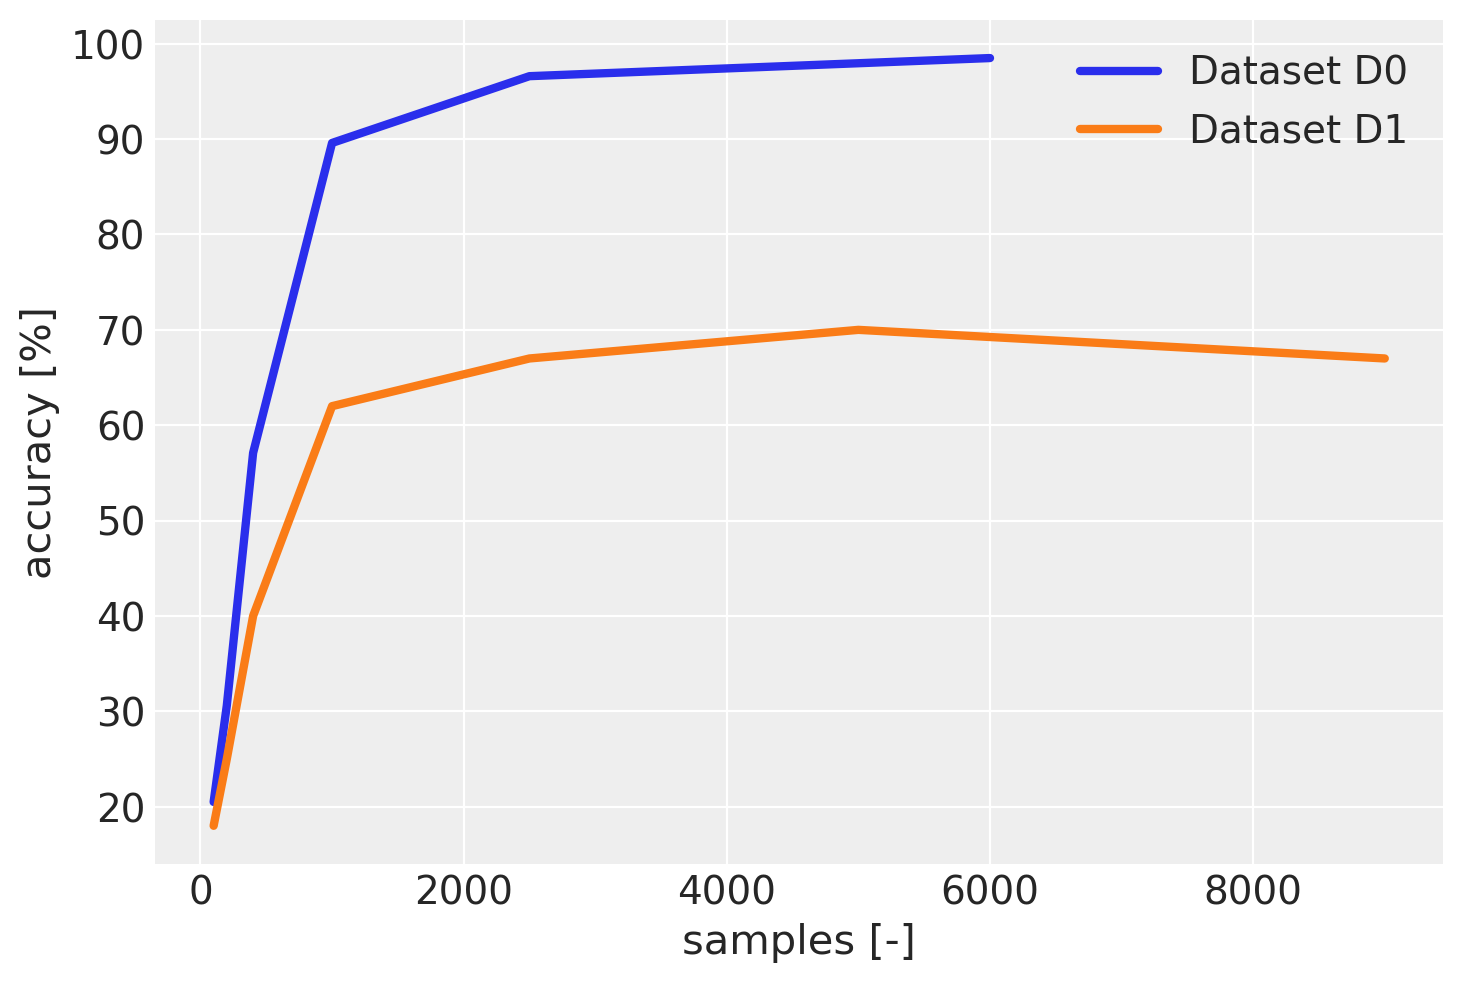

In [35]:
plt.plot([100,200,400,1000,2500,6000], [20.5,30.6,57.1,89.6,96.6,98.5], linewidth=3)
plt.plot([100,200,400,1000,2500,5000,9000], [18,25,40,62,67,70,67], linewidth=3)
plt.xlabel("samples [-]")
plt.ylabel("accuracy [%]")
plt.legend(['Dataset D0','Dataset D1'])
plt.savefig(os.path.abspath("./cbgo_accuracy_on_samples.svg"))

Helper functions:

In [1]:
def my_callback(meanfield, elbo, n):
    if n%2000 == 0:# and n>200:
        acc = print_acc_from_trace(meanfield, n)
        accs.append(acc)
        ns.append(n)
def ppc_to_pred(ppc):
    pred = []
    for i in range(ppc['out'].shape[1]): # for X_test samples
        one_sample = []
        for j in range(ppc['out'].shape[0]):
            one_sample.append(ppc['out'][j][i])
        sums = np.zeros(lenA)
        for s in one_sample:
            sums[s] += 1

        pred.append(np.argmax(sums))
    return np.array(pred)

Used in callback. Computes, prints and saves the accuracy at this point of learning

In [2]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [3]:
def print_acc_from_trace_train(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_train})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_train).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

# Models (M2,..M5)

- 2 Layers NN 
- M2 - Gesture + Target object
- M3 - Gesture + User
- M4 - Gesture + Target_object + User
- M5 - Gesture + Target_object + User + Object state

id   |features                                             | D0   | D1   | D2   | D3   | D1 2G | D2 2G | D3 2G
---  | -------------------------------------------------   | ---- | ---- | ---- | ---- | ----- | ----- | -----
M2v0 | no                                                  | 99.4 | 67.5 | 67.2 | 67.3 | 93.8  | 92.5  |
M2v2 | Target object                                       | 97+  | 72   | 72.2 | 71.5 | 96.8  | 95.0
M2v3 | Target object + attached                            | 95+  | 73   | 73   | -    | 96.9  |
M2v4 | Target object + attached + objects                  | -    | 68   | 72.7 | -    | 94.1  |
M2v5 | Target object + eef field + attached + objects      | -    | 73+  | 73   | 73.6+| -     | 95.1
M2v6 | focus diffs + eef diffs + attached + objects        | -    | n    | n    | -    | -
M2v7 | object type holding                                 | -    | -    | 68.5 |
M2v1 | all in                                              | -    | n    | n 
M3v0 | user                                                | 99.4 |-67.5-|-67.2-| 67.3 | 93.8  |-92.5- | 92.2
M3v5 | user + Target object + eef field + attached + objects|
M3v2 | user + Target object
M3v8 | user + Target object + object state

new name | id   | additional features                                | D1_1+σ| D2_1+σ |D3_1+σ |D4_1+σ   | D3
-------- | ---  | ------------------------------------------------   | ----- | ------ | ----- | ------- | ---
M1       | M1   | -                                                  | -     | -      | -     | 72      | 67.3
x        | M2v0 | -                                                  | 99.4  | 84.2   | 70.4  | 71.5    | x
M2       | M2v2 | Target object                                      | 99.6  | 99.2   | 79.1  | 79.2    | 71.5
M3       | M3v0 | user                                               | 99.6  | 84.1   | 87.7  | 78.8    | 67.3
M4       | M3v2 | user + Target object                               | 99.6  | 99.5   |97.7+.2|92.6+4.6 | 73.7
M5       | M3v8 | user + Target object + object state                |99.3+.3|99.4+.04|97.1+.3|97.4     | 74.0
x        | M3v10| user + Target object + object state + object_types |       |99.1+0.3|94.5+2.|88.2+0.1 | 74.1 

new name | id   | additional features                                | D5    |
-------- | ---  | ------------------------------------------------   | ----- |
M1       | M1   | -                                                  |       | 
x        | M2v0 | -                                                  |       | 
M2       | M2v2 | Target object                                      |       |
M3       | M3v0 | user                                               |       |
M4       | M3v2 | user + Target object                               |       |
M5       | M3v8 | user + Target object + object state                | 92.6  |
x        | M3v10| user + Target object + object state + object_types |       |

In [1]:
try:
    import aesara; floatX = aesara.config.floatX
except ModuleNotFoundError:
    import theano; floatX = theano.config.floatX
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene
from srcmodules.Users import Users
from srcmodules.Objects import Object

%config InlineBackend.figure_format = 'retina'
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
import rclpy
rclpy.init()

In [6]:
dataset_name = 'D6'
n_obs_in = 70
train_samples = 4000 
scene_def_id = 10
user_dep=True

In [7]:
# dataset 
data = np.load(f"{os.path.expanduser('./datasets')}/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [8]:
Object.all_types = Otypes

In [9]:
Object.all_types

['cup', 'drawer', 'object']

In [10]:
def get_X_Y(dataset, user_dep=False):
    X = np.zeros([len(dataset), n_obs_in])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = s.scene_to_observation(type=scene_def_id, focus_point=sample[3])
        
        if not user_dep:
            ll = len(sample[2]) + len(obs)
            X[n,0:ll] = [*sample[2], *obs]
        else:
            ll = len(sample[2]) + 1 + len(obs)
            X[n,0:ll] = [*sample[2], Users.U.index(sample[0]['user']), *obs]
        
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset, user_dep=user_dep)

In [11]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-(train_samples/10000))

In [12]:
def construct_nn(nn_input, nn_output):
    n_hidden = 25

    init_weights_1 = rng.standard_normal(size=(n_obs_in, n_hidden)).astype(floatX)
    init_weights_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_weights_3 = rng.standard_normal(size=(n_hidden, lenA)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "hidden_layer_3": np.arange(n_hidden),
        "train_cols": np.arange(n_obs_in),
        "out_dim": np.arange(lenA),
    }
    with pm.Model(coords=coords) as neural_network:
        nn_input = pm.Data("nn_input", nn_input)
        nn_output = pm.Data("nn_output", Y_train)

        # Weights from input to hidden layer
        weights_1 = pm.Normal(
            "weights_1", 0, sigma=1, testval=init_weights_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_2 = pm.Normal(
            "weights_2", 0, sigma=1, testval=init_weights_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_3 = pm.Normal(
            "weights_3", 0, sigma=1, testval=init_weights_3, dims=("hidden_layer_2", "out_dim")
        )
        
        act_1   = pm.math.tanh(pm.math.dot(nn_input, weights_1))
        act_2   = pm.math.tanh(pm.math.dot(weights_1, weights_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_1, weights_3))
        
        out = pm.Categorical("out", act_out, observed=nn_output, total_size=Y_train.shape[0])
        
    return neural_network

neural_network = construct_nn(X_train, Y_train)

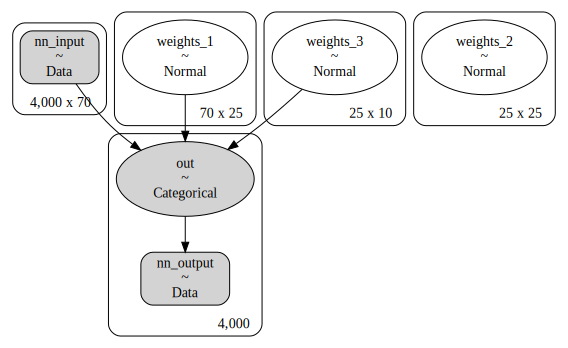

In [13]:
pm.model_to_graphviz(neural_network)

In [14]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [15]:
ns = []
accs = []
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    method = pm.ADVI()
    approx = pm.fit(n=60_000, callbacks=[my_callback], method=method)

n: 2000, Accuracy = 14.15%
n: 4000, Accuracy = 15.1%
n: 6000, Accuracy = 16.85%
n: 8000, Accuracy = 18.47%
n: 10000, Accuracy = 19.63%
n: 12000, Accuracy = 24.5%
n: 14000, Accuracy = 29.45%
n: 16000, Accuracy = 36.1%
n: 18000, Accuracy = 42.77%
n: 20000, Accuracy = 56.65%
n: 22000, Accuracy = 77.03%
n: 24000, Accuracy = 92.42%
n: 26000, Accuracy = 96.88%
n: 28000, Accuracy = 97.62%
n: 30000, Accuracy = 98.73%
n: 32000, Accuracy = 99.1%
n: 34000, Accuracy = 99.0%
n: 36000, Accuracy = 99.02%
n: 38000, Accuracy = 99.2%
n: 40000, Accuracy = 99.35%
n: 42000, Accuracy = 99.37%
n: 44000, Accuracy = 99.22%
n: 46000, Accuracy = 99.38%
n: 48000, Accuracy = 99.32%
n: 50000, Accuracy = 99.42%
n: 52000, Accuracy = 99.45%
n: 54000, Accuracy = 99.4%
n: 56000, Accuracy = 99.58%
n: 58000, Accuracy = 99.37%
n: 60000, Accuracy = 99.38%


Finished [100%]: Average Loss = 1,289.9


In [16]:
network_path = "/home/petr/ros2_ws/src/context_based_gesture_operation/context_based_gesture_operation/trained_networks/"
name = 'M3v10_'+dataset_name

In [17]:
from srcmodules.nnwrapper import NNWrapper
args = {'A': A, 'G': G, 'lenG': lenG, 'lenA': lenA, 'Otypes': Otypes, 'lenOtypes': lenOtypes, 'CM': CM, 'dataset_name': dataset_name, 'scene_def_id': scene_def_id, 'user_dep': user_dep}

NNWrapper.save_network(X_train, approx, neural_network, network_path=network_path, name=name, Gs=A, type='g2i', engine='PyMC3', args=args, accuracy=accs[-1], filenames=[], record_keys=[])

Saving network
Network: M3v10_D6.pkl saved


Test the network on test data

In [9]:
from srcmodules.nnwrapper import NNWrapper
network_path = "/home/petr/ros2_ws/src/context_based_gesture_operation/context_based_gesture_operation/trained_networks/"
load_model = 'M3v10_D5.pkl'
nn = NNWrapper.load_network(network_path, name=load_model)

In [13]:
from agent_nodes.g2i import G2IRosNode, PyMC3_Sample
load_model = 'M3v10_D5.pkl'
g2i_tester = G2IRosNode(load_model=load_model)

In [14]:
import sys
from ament_index_python.packages import get_package_share_directory
# may raise PackageNotFoundError
package_share_directory = get_package_share_directory('teleop_gesture_toolbox')
sys.path.append(package_share_directory)

In [15]:
predic = []
for x,y in zip(X_test,Y_test):
    inference_probs = g2i_tester.sampler.sample(x)
    action_id = np.argmax(inference_probs)
    predic.append(action_id)
        
predic = np.array(predic)
y_test = np.array(Y_test, dtype=int)

In [16]:
from teleop_gesture_toolbox.os_and_utils.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

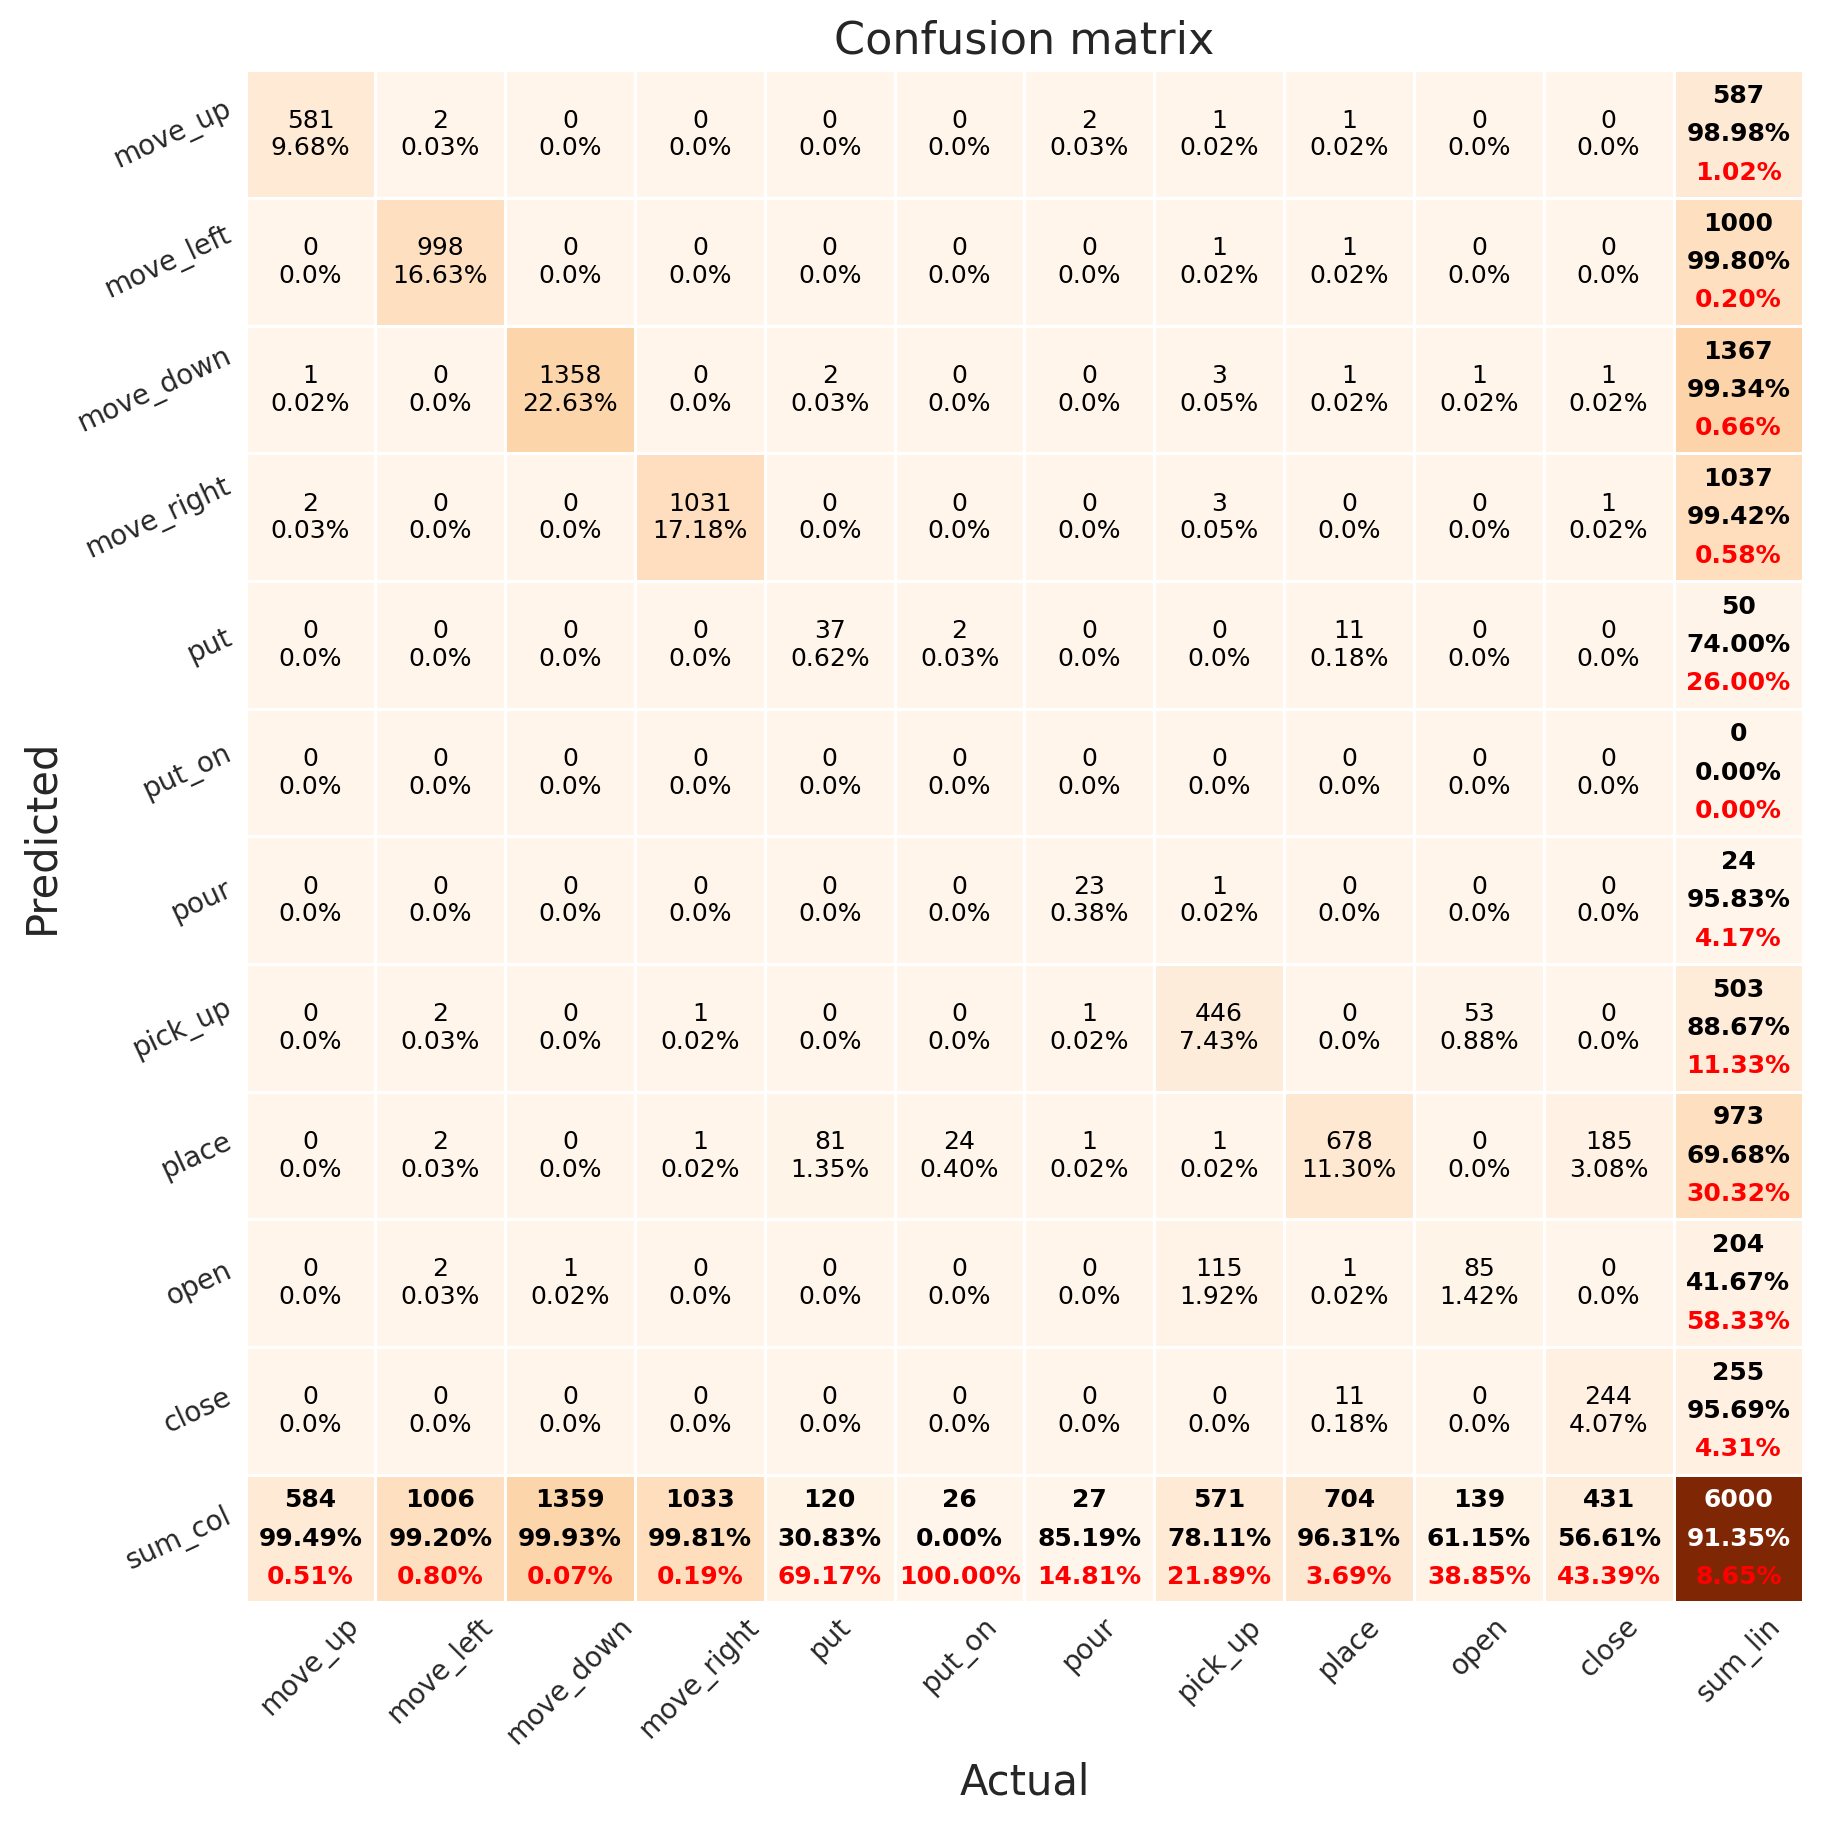

In [17]:
columns = g2i_tester.A
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [4,4];
if(len(y_test) > 10):
    fz=9; figsize=[9,9];
plot_confusion_matrix_from_data(y_test, predic, columns, annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

In [18]:
predic = []
for x,y in zip(X_train,Y_train):
    inference_probs = g2i_tester.sampler.sample(x)
    action_id = np.argmax(inference_probs)
    predic.append(action_id)
        
predic = np.array(predic)

In [19]:
y_test = np.array(Y_train, dtype=int)

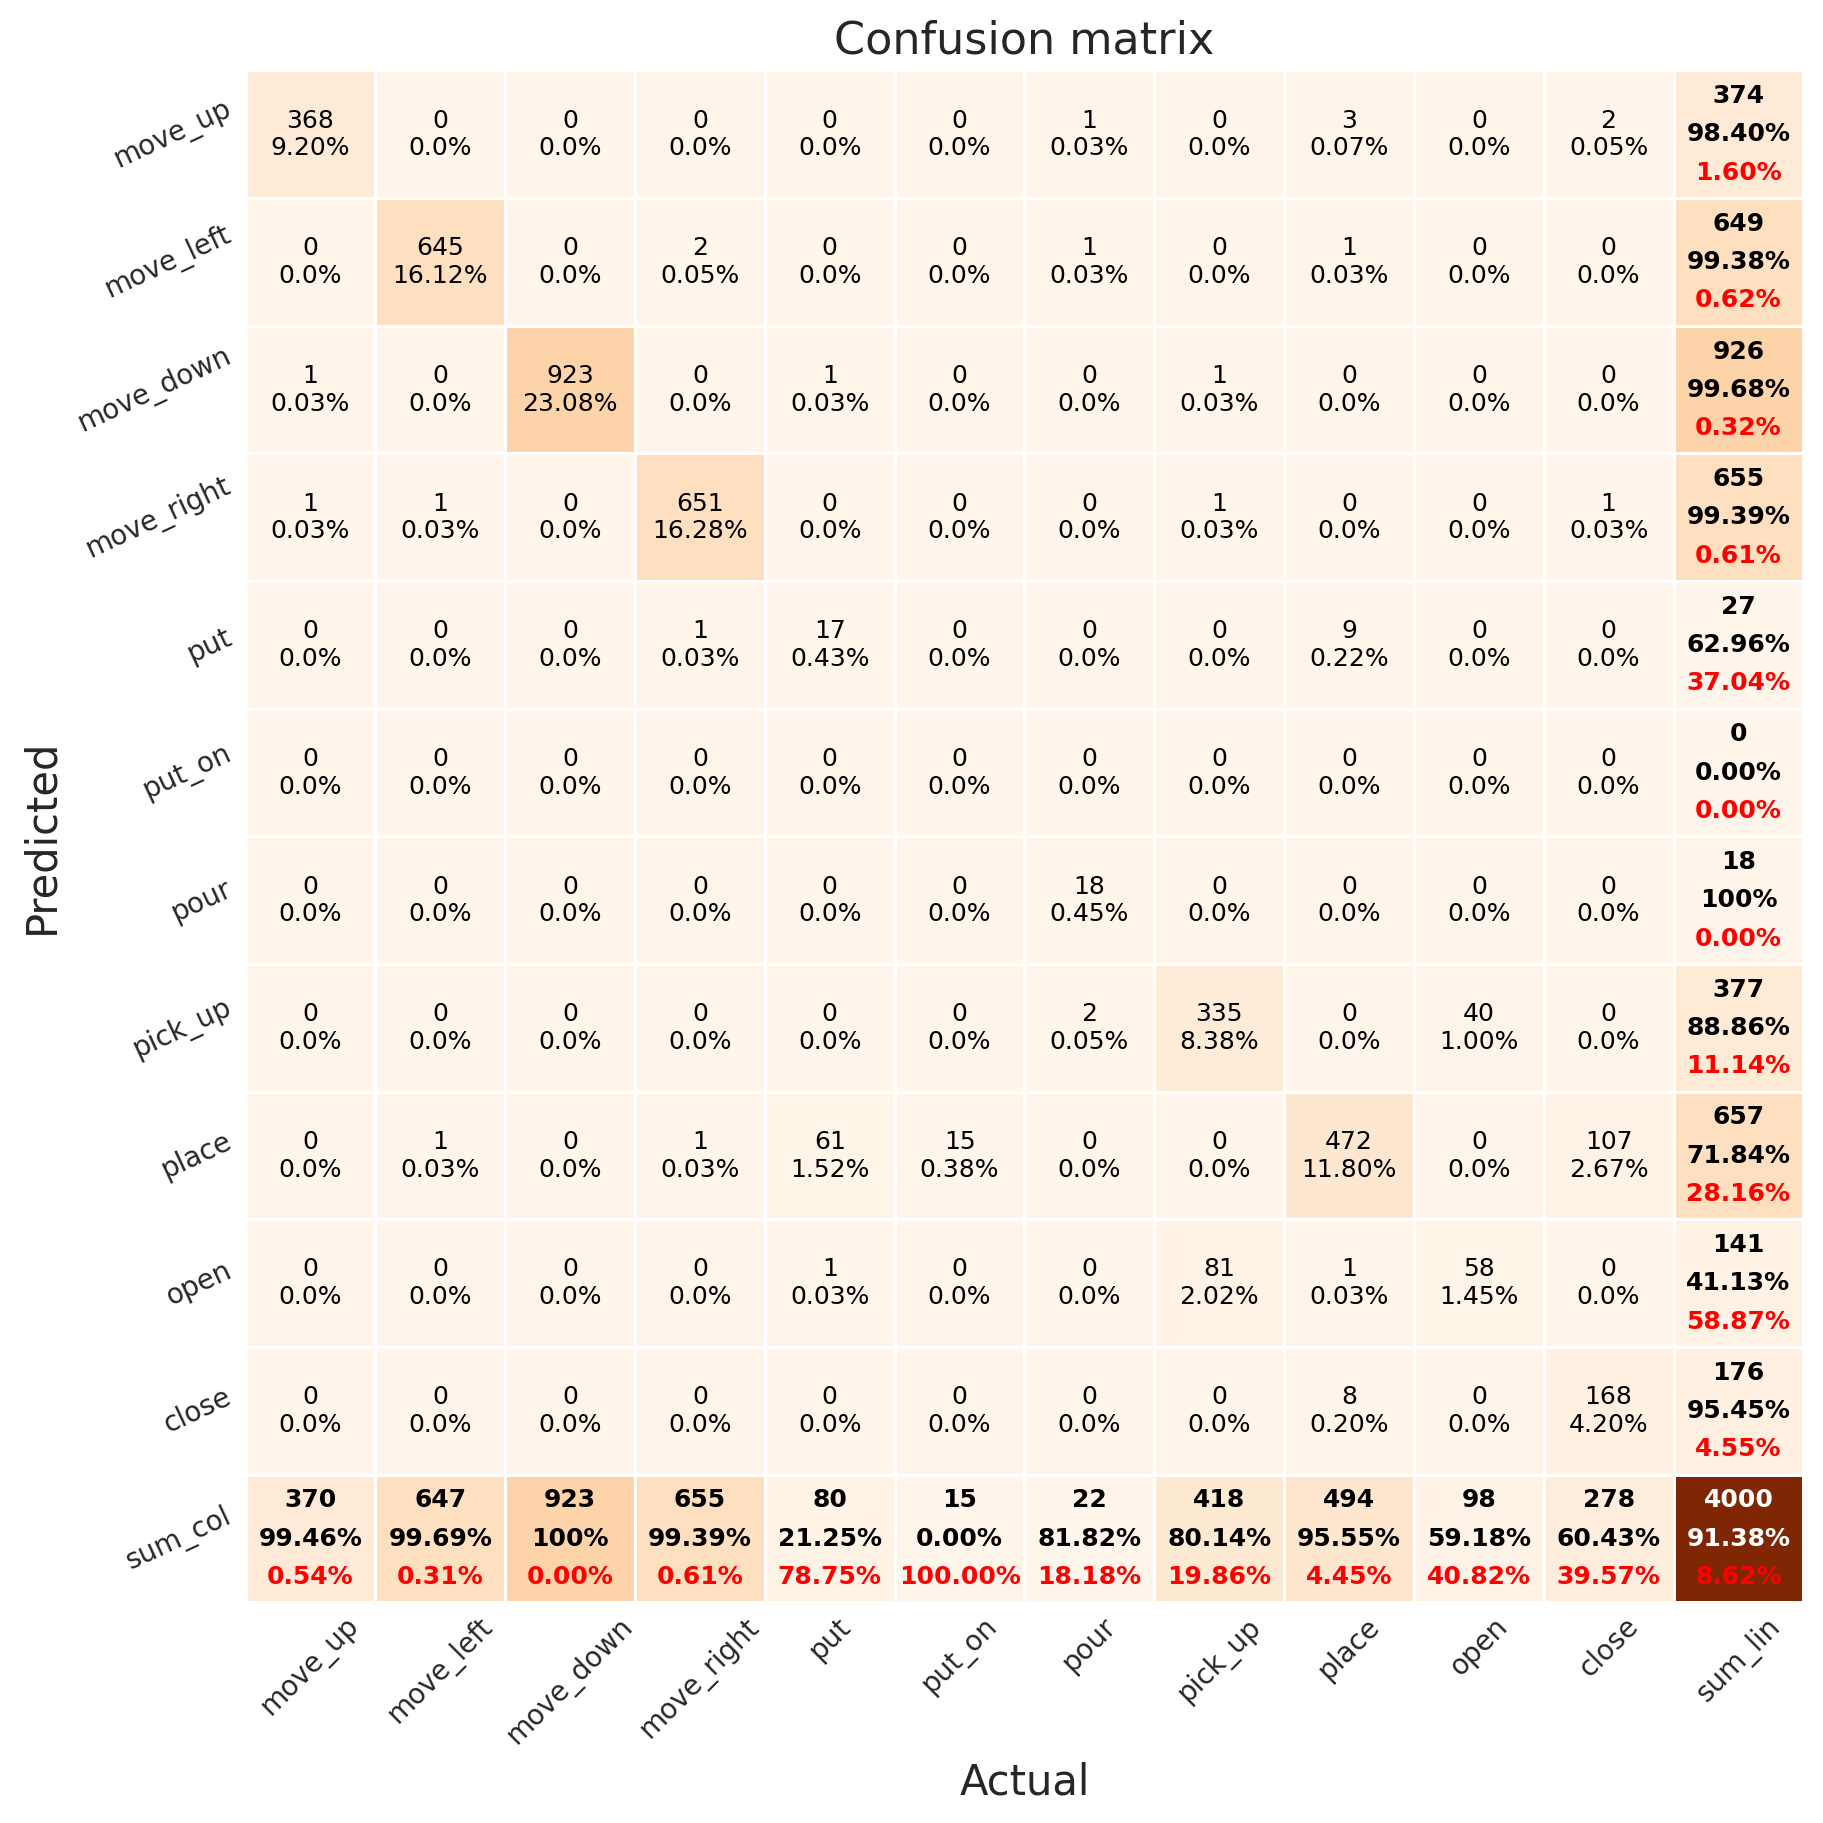

In [20]:
columns = g2i_tester.A
annot = True;
cmap = 'Oranges';
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
#size::
fz = 12;
figsize = [4,4];
if(len(y_test) > 10):
    fz=9; figsize=[9,9];
plot_confusion_matrix_from_data(y_test, predic, columns, annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

# Model using 3 layers



In [108]:
try:
    import aesara; floatX = aesara.config.floatX
except ModuleNotFoundError:
    import theano; floatX = theano.config.floatX
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import os
from copy import deepcopy

from sklearn.model_selection import train_test_split

from srcmodules.Scenes import Scene
from srcmodules.Users import Users

%config InlineBackend.figure_format = 'retina'
rng = np.random.default_rng(5165)
az.style.use("arviz-darkgrid")

In [88]:
dataset_name = 'D4_1'
n_obs_in = 70
train_samples = 4000 
scene_def_id = 10
user_dep=True

In [89]:
# dataset 
data = np.load(f"{os.path.expanduser('./datasets')}/{dataset_name}.npy", allow_pickle=True)
config = data.item()['config']
A = config['A']
G = config['G']
lenG = config['lenG']
lenA = config['lenA']
Otypes = config['Otypes']
lenOtypes = config['lenOtypes']
CM = config['CM']
dataset = data.item()['dataset']

In [91]:
def get_X_Y(dataset, user_dep=False):
    X = np.zeros([len(dataset),n_obs_in])
    Y = np.zeros((len(dataset)), dtype=tuple)
    for n,sample in enumerate(dataset):
        s = Scene(init='from_dict', import_data=sample[0])
        obs = s.scene_to_observation(type=scene_def_id, focus_point=sample[3])
        
        if not user_dep:
            ll = len(sample[2]) + len(obs)
            X[n,0:ll] = [*sample[2], *obs]
        else:
            ll = len(sample[2]) + 1 + len(obs)
            X[n,0:ll] = [*sample[2], Users.U.index(sample[0]['user']), *obs]
        #X[n] = sample[2]
        Y[n] = A.index(sample[1][0])
    return X, Y

X,Y = get_X_Y(dataset, user_dep=user_dep)

In [92]:
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-(train_samples/10000))

In [93]:
def construct_nn(nn_input, nn_output):
    n_hidden = 25

    # Initialize random weights between each layer
    init_weights_1 = rng.standard_normal(size=(n_obs_in, n_hidden)).astype(floatX)
    init_weights_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_weights_3 = rng.standard_normal(size=(n_hidden, lenA)).astype(floatX)
    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "hidden_layer_3": np.arange(n_hidden),
        "train_cols": np.arange(n_obs_in),
        "out_dim": np.arange(lenA),
    }
    with pm.Model(coords=coords) as neural_network:
        nn_input = pm.Data("nn_input", nn_input)
        nn_output = pm.Data("nn_output", Y_train)

        # Weights from input to hidden layer
        weights_1 = pm.Normal(
            "weights_1", 0, sigma=1, testval=init_weights_1, dims=("train_cols", "hidden_layer_1")
        )
        weights_2 = pm.Normal(
            "weights_2", 0, sigma=1, testval=init_weights_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        weights_3 = pm.Normal(
            "weights_3", 0, sigma=1, testval=init_weights_3, dims=("hidden_layer_2", "out_dim")
        )
        
        act_1   = pm.math.tanh(pm.math.dot(nn_input, weights_1))
        act_2   = pm.math.tanh(pm.math.dot(act_1, weights_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_3))
        
        out = pm.Categorical("out", act_out, observed=nn_output, total_size=Y_train.shape[0])
        
    return neural_network

neural_network = construct_nn(X_train, Y_train)

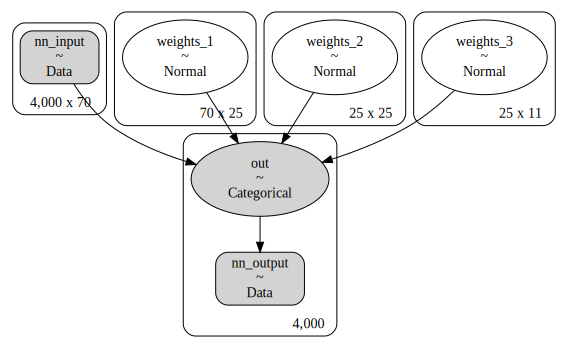

In [94]:
pm.model_to_graphviz(neural_network)

In [95]:
def print_acc_from_trace(meanfield, n, draws=20):
    neural_network_test = deepcopy(neural_network)
    with neural_network_test:
        trace = meanfield.sample(draws=draws)
    
        pm.set_data(new_data={"nn_input": X_test})
        ppc = pm.sample_posterior_predictive(trace, progressbar=False)
    
    pred = ppc_to_pred(ppc)
    acc = (pred == Y_test).mean() * 100
    print(f"n: {n}, Accuracy = {round(acc,2)}%")
    return acc

In [96]:
ns = []
accs = []
neural_network = construct_nn(X_train, Y_train)
with neural_network:
    method = pm.ADVI()
    approx = pm.fit(n=40_000, callbacks=[my_callback], method=method)

Interrupted at 24 [0%]: Average Loss = 16,146
